# Log-Contract Example

The example '04_BlackScholesPricer_example.ipynb' introduces the Black-Scholes option pricing model, which can be used to price European call and put options. Breeden and Litzenberger pricing model is, in turn, used for pricing some exotic functions. This notebook considers the use of Breeden-Litzenberger model for pricing log-contracts - a type of path-independent exotic option.

In [1]:
# Setup for the notebook
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from quantform.pylib import QfDate
from quantform.pylib.equity.utils import parse_option_id, form_option_id
from quantform.pylib.equity.derivative import Option, LogContract
from quantform.pylib.curve import ImpliedVolatilityCurve

project_root = Path(os.path.abspath(""))

LogContract

quantform.pylib.equity.derivative.LogContract.LogContract

## Implied volatility

Implied volatility curve is required for pricing with the Breeden-Litzenberger pricer, so the first thing to do is to calculate it.

In [2]:
# Calculate the implied volatility curve
report_date = QfDate(2025, 8, 15, calendar="NYSE")

# The used risk-free rate is the yield of a two year US Treasury quoted EOD 2025-08-15
risk_free_rate = 0.03755

# The value of the underlying is also quoted EOD 2025-08-15. Use a slightly smaller value so that the implied vol can be
# calculated. This is required as the bids and asks might not be up to date
underlying_value = 630  # Actual 643.44 USD

# Read the market data from a CSV file. The market data covers the option prices quoted EOD 2025-08-15 for all available SPY options
option_df = pd.read_csv(project_root / "example_data" / "SPY_Calls_2025-08-15.tsv", sep='\t')

# Function that creates an Option object from the given option price data. If the implied volatility cannot be calculated skips the option
def to_option(row: pd.Series) -> Option:
  try:
    return Option(row["Contract Name"], *parse_option_id(row["Contract Name"], calendar="NYSE"), risk_free_rate=risk_free_rate, 
                  market_price=(row["Bid"] + row["Ask"]) / 2, underlying_value=underlying_value, report_date=report_date)
  except AssertionError as e:
     print(f"Not able to calculate the implied volatility for option {row["Contract Name"]}! ({e})")
         
# Note that calculating the implied volatilities for thousands of options is quite computationally expensive.
# However, as going forward the same underlying value and report date will be used, it is enough to do this just once
options = [to_option(row) for _, row in option_df.iterrows() if row["Contract Name"].startswith("SPY271217C")]
options = [option for option in options if option is not None]

Not able to calculate the implied volatility for option SPY271217C00225000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 423.8748032210278))
Not able to calculate the implied volatility for option SPY271217C00230000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 72.82424329260618))
Not able to calculate the implied volatility for option SPY271217C00235000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 414.7136833641846))
Not able to calculate the implied volatility for option SPY271217C00240000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 72.26812343576296))
Not able to calculate the implied volatility for option SPY271217C00265000! (Implied volatility can't be calculated as the lower bound difference is not negative! (Lower bound is 38.75032379365496))
Not a

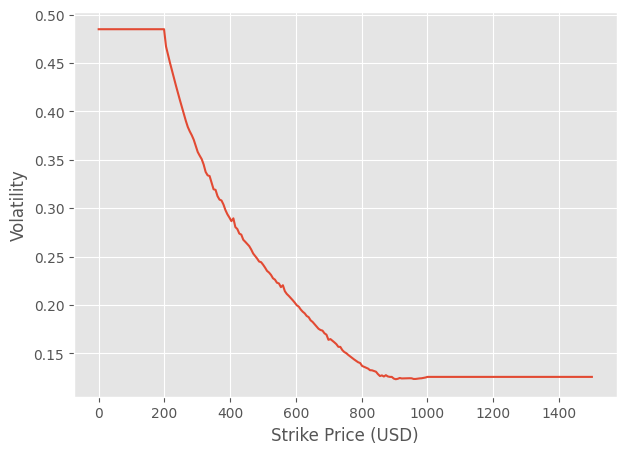

In [3]:
curve_date = QfDate(2027, 12, 17, calendar="NYSE")
curve_options = [option for option in options if option.maturity_date == curve_date]

curve = ImpliedVolatilityCurve(curve_options, underlying_value, report_date)
fig = curve.plot(250, value_range=(0, 1500))

# plt.plot([option.strike for option in curve_options], [option.pricer.volatility for option in curve_options], '.')
plt.xlabel("Strike Price (USD)")
plt.ylabel("Volatility")
plt.show()

## Breeden-Litzenberger

In [4]:
log_contract = LogContract("test", "SPY", curve_date, underlying_value, risk_free_rate, curve)

In [5]:
print("Price:", log_contract(underlying_value, report_date, integration_interval=(200, 1000)))
print("Delta:", log_contract.delta(underlying_value, report_date, integration_interval=(200, 1000)))
print("Vega: ", log_contract.vega(underlying_value, report_date, integration_interval=(200, 1000)))

Price: 0.07249673415588737
Delta: 0.0012896452499449736
Vega:  -0.27599123297690925


## Implied Density

In [6]:
implied_density = log_contract.pricer.implied_density(underlying_value, report_date)

In [7]:
print("Mean:", implied_density.mean)
print("Std: ", implied_density.std)
print("Skew:", implied_density.skew)
print("Kurt:", implied_density.kurtosis)

Mean: 714.8823404373286
Std:  544159.3704491911
Skew: 435203042.63236475
Kurt: 363143807433.7271


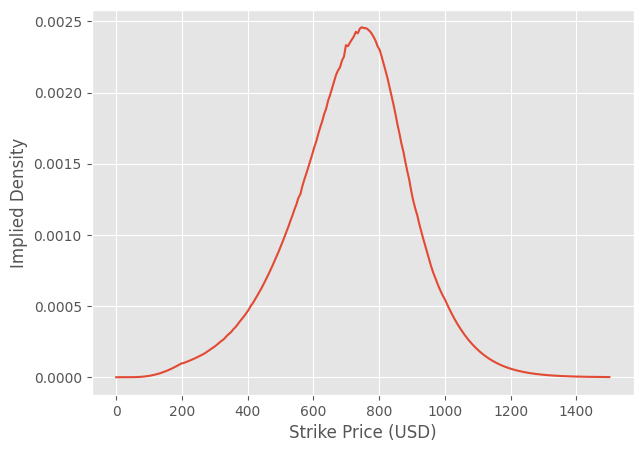

In [8]:
fig = implied_density.plot(250)

plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Density")
plt.show()

In [9]:
print("Probability covered:", implied_density.interval(200, 1000))

Probability covered: 0.944917652318576


## Neuberger

In [10]:
log_contract2 = LogContract("test", "SPY", curve_date, underlying_value, risk_free_rate, curve, 'Neuberger')

In [11]:
print("Price:", log_contract2(underlying_value, report_date))
print("Delta:", log_contract2.delta(underlying_value, report_date))
print("Vega: ", log_contract2.vega(underlying_value, report_date))

Price: -0.04187441883605299
Delta: 0.0015873015873015873
Vega:  -0.44205650608066754
